In [652]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('classic')
# print(plt.style.available)

%matplotlib inline
mpl.rcdefaults()
plt.rcParams['image.cmap'] = 'gray'

import os
if os.name == 'posix': # 如果系统是mac或者linux
    plt.rcParams['font.sans-serif'] = ['Songti SC'] #中文字体为宋体
else:
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 在windows系统下显示微软雅黑
plt.rcParams['axes.unicode_minus'] = False # 负号用 ASCII 编码的-显示，而不是unicode的 U+2212

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)

from tqdm import trange


# 定价及希腊字母

https://3c.wind.com.cn/l/BhHE?shareUserSign=FmFnE

完成雪球期权的定价模型并计算出相关的希腊值（delta，gamma， vega，rho，theta）。

## 蒙特卡洛模拟股价过程

|参数| 取值|
|-|-|
|名义本金 | 1 亿元|
|保证金比例 | 100%|
|波动率 (σ) | 16%|
|无风险利率 (r) | 3%|
|融券成本 (q) | 9.5%|
|敲出票息 | 16%|
|红利票息 | 16%|
|期限 | 24 个月|
|锁定期 | 3 个月|
|敲出价格 | 100%|
|敲入价格 | 75%|
|stepdown | 0.5%|
|stepdown 开始期 | 第四个月|

## 用np.zeros提速

In [ ]:
Position = 1e8
margin = 1
sigma = 0.16
r_riskfree = 0.03
q = 0.095
knock_out_coupon = 0.16
hold_coupon = 0.16
T_years = 2
lock_peroiod = 0.25 # 与敲出期有关，只锁定敲出不锁定敲入
knock_out_barrier = 1
knock_in_barrier = 0.75
stepdown = 0.005 # 这是逐级下调雪球产品，展示敲出期的变化规律
stepdown_start = 4/12

S0 = 1
K = S0

In [ ]:
start_date = pd.to_datetime('2021-01-05')
end_date = start_date + pd.DateOffset(years=T_years)
date_index = pd.date_range(start=start_date, end=end_date, freq='D')
T_days = len(date_index)
date_index

DatetimeIndex(['2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14',
               ...
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05'],
              dtype='datetime64[ns]', length=731, freq='D')

In [ ]:
def bs_model_price(S0, r, sigma, T_years, T_days):
    dt = T_years/T_days
    t = np.linspace(0, T_years, T_days)
    W = np.random.standard_normal(size=T_days)
    W = np.cumsum(W)*np.sqrt(dt)
    X = (r-q-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X)
    return S


In [630]:
def simulation(S0, r_riskfree, q, sigma, T_years, sample_size = 10000, steps = 365, plotpath = False, plothist = False):
    # dn是啥
    delta_t = 1/steps
    Spath = np.zeros((T_years * steps + 1, I))
    Spath[0] = S0

    for t in trange(1, T_years * steps + 1):
        z = np.random.standard_normal(sample_size)
        middle1 = Spath[t-1, 0:sample_size] * np.exp((r_riskfree - q - 0.5 * sigma ** 2) * delta_t + sigma * np.sqrt(delta_t) * z)
        uplimit = Spath[t-1] * 1.1 # 涨幅限制
        lowlimit = Spath[t-1] * 0.9 # 跌幅限制
        temp = np.where(uplimit < middle1, uplimit, middle1)
        temp = np.where(lowlimit > middle1, lowlimit, temp)
        Spath[t, 0:sample_size] = temp

    return Spath

In [633]:
stock_price_array = simulation(S0, r_riskfree, q, sigma, T_years, I = 10000,dn = 0, steps = 365, plotpath = False, plothist = False)
stock_price_df = pd.DataFrame(stock_price_array, index = date_index)

100%|██████████| 730/730 [00:00<00:00, 2369.58it/s]


In [764]:
import os
if not os.path.exists('./result/'):   #os：operating system，包含操作系统功能，可以进行文件操作
    os.mkdir('./result/') #如果存在那就是这个result_path，如果不存在那就新建一个

class my_plot():  # 后面再封装一些其他函数
    def __init__(self, plot_df, plot_name):
        self.plot_df = plot_df
        self.plot_name = plot_name

    def line_plot(self):  # name包括title，xlabel，ylabel，save_name
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        fontsize = 12
        x = self.plot_df.index
        y_labels = self.plot_df.columns
        for i in trange(len(y_labels)):
            clmn = y_labels[i]
            axes.plot(x, self.plot_df.loc[:, clmn].values, label=clmn)
        axes.set_title(f'{self.plot_name[0]}', fontsize=fontsize)
        axes.set_xlabel(f'{self.plot_name[1]}', fontsize=fontsize)
        axes.set_ylabel(f'{self.plot_name[2]}', fontsize=fontsize)
        axes.grid()
        # plt.legend()
        # plt.legend(fontsize = fontsize * 0.7, loc = 'best',ncol = 10,bbox_to_anchor=(1.03, -0.25))
        # axes.set_xticks( range(0,21,2) )
        # axes.set_xticklabels( [i for i in axes.get_xticks()], rotation=0 )
        mpl.rc('xtick', labelsize=fontsize)
        mpl.rc('ytick', labelsize=fontsize)
        plt.savefig(f"./result/{self.plot_name[3]}_line_plot.jpg", bbox_inches='tight', dpi=300, pad_inches=0.0)
        # plt.show()
    def hist_plot(self):
        fig, ax = plt.subplots(figsize=(10, 5))
        
        fontsize = 12
        ax.hist(self.plot_df,bins = 20)
        ax.set_title(f'{self.plot_name[0]}', fontsize=fontsize)
        ax.set_xlabel(f'{self.plot_name[1]}', fontsize=fontsize)
        ax.set_ylabel(f'{self.plot_name[2]}', fontsize=fontsize)
        plt.savefig(f"./result/{self.plot_name[3]}_hist_plot.jpg", bbox_inches='tight', dpi=300, pad_inches=0.0)
    
    def quantiles_plot(self):
        qtl_df = self.plot_df
        qtl_df.dropna(inplace=True)
        qtl_df = qtl_df.rank() / len(qtl_df)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        fontsize = 12

        ax.scatter(qtl_df['x'], qtl_df['y'], s=0.00001)
        ax.set_title(f'{self.plot_name[0]}', fontsize=fontsize)
        ax.set_xlabel(f'{self.plot_name[1]}', fontsize=fontsize)
        ax.set_ylabel(f'{self.plot_name[2]}', fontsize=fontsize)
        ax.grid()
        # plt.legend(fontsize = fontsize * 0.7, loc = 'best',ncol = 10,bbox_to_anchor=(1.03, -0.25))
        # ax.set_xticks( range(0,21,2) )
        # ax.set_xticklabels( [i for i in ax.get_xticks()], rotation=0 )
        mpl.rc('xtick', labelsize=fontsize)
        mpl.rc('ytick', labelsize=fontsize)
        plt.savefig(f"./result/{self.plot_name[3]}_quantiles_plot.jpg", bbox_inches='tight', dpi=300, pad_inches=0.0)
        # plt.show()
    
    def bar_plot(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        hist_x = [str(x) for x in self.index]
        hist_y = self.values
        ax.bar(hist_x, hist_y)
        ax.set_xlabel('逐笔交易对应时间',fontsize = 30)
        ax.set_ylabel('频数',fontsize = 30)
        plt.savefig(f"./result/{self.plot_name[3]}_bar_plot.jpg", bbox_inches='tight', dpi=300, pad_inches=0.0)
        

100%|██████████| 10000/10000 [00:07<00:00, 1256.38it/s]


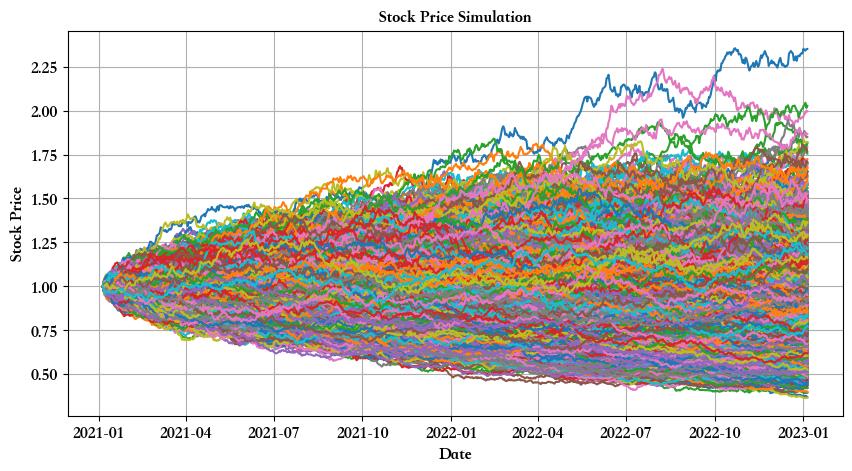

In [749]:
_ = my_plot(stock_price_df,['Stock Price Simulation','Date','Stock Price','stock_price'])
_.line_plot()

In [771]:
paramter_name = ['Position', 'margin', 'sigma', 'r_riskfree', 'q', 'knock_out_coupon', 'hold_coupon', 'T_years', 'lock_peroiod', 'knock_out_barrier', 'knock_in_barrier', 'stepdown', 'stepdown_start']
paramter_value = [1.00E+08, 1, 0.16, 0.03, 0.095, 0.16, 0.16, 2, 0.25, 1, 0.75, 0.005,  4/12]
pd.DataFrame({k:[v] for k, v in zip(paramter_name, paramter_value)})

,Position,margin,sigma,r_riskfree,q,...,lock_peroiod,knock_out_barrier,knock_in_barrier,stepdown,stepdown_start
0,100000000.0,1,0.16,0.03,0.095,...,0.25,1,0.75,0.005,0.333333


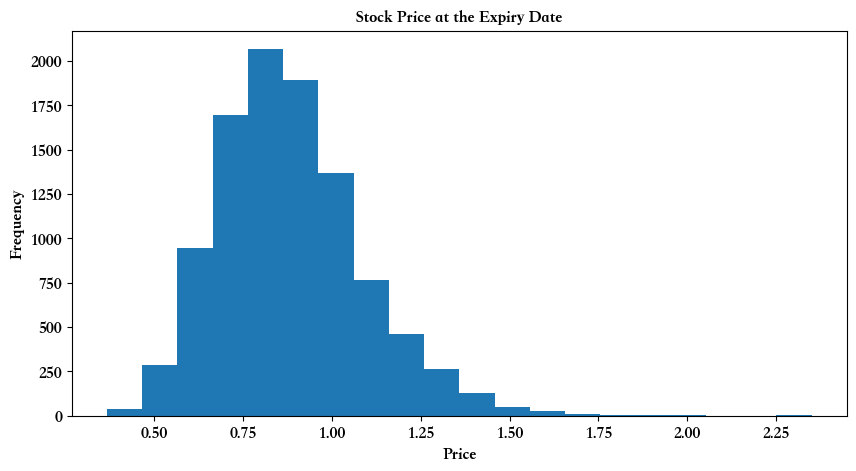

In [767]:
_ = my_plot(stock_price_df.iloc[-1,:],['Stock Price at the Expiry Date','Price','Frequency','stock_price'])
_.hist_plot()

1. 每月观察期敲出，则终止并获得全部本金和年化敲出票息；

2. 没有敲入也没有敲出，则期末获得全部本金和年化红利票息；

3. 每日观察期敲入，期末未敲出，则获得与收益凭证本金相同的看跌空头，行权价为收益凭证本金相同数额。

In [680]:
from datetime import datetime
date_lst = ['20210406', '20210506', '20210607', '20210705', '20210805', '20210906', '20211008', '20211105', '20211206', '20220105', '20220207', '20220307', '20220406', '20220505', '20220606', '20220705', '20220805', '20220905', '20221010', '20221107', '20221205', '20230105']
date_lst = [datetime.strptime(date, '%Y%m%d') for date in date_lst]
# stepdown_lst = [1.000,1.000, 1.000, 0.995, 0.990, 0.985, 0.980, 0.975, 0.970, 0.965, 0.960, 0.955, 0.950, 0.945, 0.940, 0.935, 0.930, 0.925, 0.920, 0.915, 0.910, 0.905]
stepdown_lst = [1.000] * 2 + [round(1 - 0.005 * i,3) for i in range(20)]
knock_in_out_df = pd.DataFrame(index = date_lst, data = {'knock_in_lst': knock_in_barrier, 'knock_out_lst': stepdown_lst})
knock_in_out_df

,knock_in_lst,knock_out_lst
2021-04-06,0.75,1.000
2021-05-06,0.75,1.000
2021-06-07,0.75,1.000
2021-07-05,0.75,0.995
2021-08-05,0.75,0.990
...,...,...
2022-09-05,0.75,0.925
2022-10-10,0.75,0.920
2022-11-07,0.75,0.915
2022-12-05,0.75,0.910


In [711]:
def price2status(stock_price_df,knock_in_out_df):
    snow_price_df = stock_price_df.loc[knock_in_out_df.index,:]
    snow_df = snow_price_df.copy()
    snow_price_df['knock_out'] = knock_in_out_df['knock_out_lst']
    snow_price_df['knock_in'] = knock_in_out_df['knock_in_lst']
    snow_df[(snow_df.T > snow_price_df['knock_out']).T] = 1
    snow_df[(snow_df.T < snow_price_df['knock_in']).T] = -1
    snow_df[abs(snow_df) != 1] = 0
    return snow_df
snowball_status = price2status(stock_price_df,knock_in_out_df)
snowball_status

,0,1,2,3,4,...,9995,9996,9997,9998,9999
2021-04-06,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0
2021-05-06,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0
2021-06-07,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0
2021-07-05,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0
2021-08-05,1.0,-1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-05,0.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,0.0,1.0,1.0
2022-10-10,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,0.0,1.0,1.0
2022-11-07,0.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,0.0,1.0,1.0
2022-12-05,0.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,0.0,1.0,1.0


In [712]:
clmn = snowball_status.columns[0]
stock_price_df.loc[:,clmn][-1]

0.9050619670270651

In [751]:
stock_price_df.iloc[-1,:]

0       0.905062
1       0.702851
2       0.697639
3       1.113303
4       0.462039
          ...   
9995    1.092815
9996    0.889994
9997    0.922266
9998    1.164595
9999    1.178524
Name: 2023-01-05 00:00:00, Length: 10000, dtype: float64

Timestamp('2021-01-05 00:00:00', freq='D')

In [731]:
def snowball_payoff(snowball_status, stock_price_df, margin, r_riskfree, knock_out_coupon, hold_coupon):    
    start_date = stock_price_df.index[0]
    payoff_lst = []
    time_out_lst = []
    knock_status_lst = []

    for clmn in snowball_status.columns:
        if snowball_status.loc[:,clmn].max() == 1: # 敲出吃利息
            time_delta = snowball_status.loc[:,clmn].idxmax() - start_date# 从这个时候贴现回来
            time_out = time_delta.days/365
            payoff = (knock_out_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
            knock_status = '敲出'
        elif snowball_status.loc[:,clmn].min() == -1: # 敲入赔期权
            time_out = T_years
            payoff = min(stock_price_df.loc[:,clmn][-1]-S0,0) * np.exp(-r_riskfree * time_out) * margin
            knock_status = '敲入'
        else:
            time_out = T_years
            payoff = (hold_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
            knock_status = '未敲入敲出'
        payoff_lst.append(payoff)
        time_out_lst.append(time_out)
        knock_status_lst.append(knock_status)
    return payoff_lst,time_out_lst, knock_status_lst
payoff_lst,time_out_lst, knock_status_lst = snowball_payoff(snowball_status, stock_price_df, margin, r_riskfree, knock_out_coupon, hold_coupon)

In [706]:
stock_price_df.loc[:,clmn][-1]

1.178523589251751

In [732]:
snowball_df = pd.DataFrame()
snowball_df['payoff'] = payoff_lst
snowball_df['time (Year)'] = time_out_lst
snowball_df['time (Month)'] = snowball_df['time (Year)'] * 12
snowball_df['knock_status'] = knock_status_lst
snowball_descriptive_df = snowball_df.groupby('knock_status').mean()
snowball_distribution_df = (snowball_df['knock_status'].value_counts()/len(snowball_df)).rename('percent')
pd.concat([snowball_descriptive_df,snowball_distribution_df],axis=1)

,payoff,time (Year),time (Month),percent
敲入,-0.302569,2.000000,24.00000,0.2068
敲出,0.076572,0.490473,5.88568,0.7599
未敲入敲出,0.301365,2.000000,24.00000,0.0333


<AxesSubplot:>

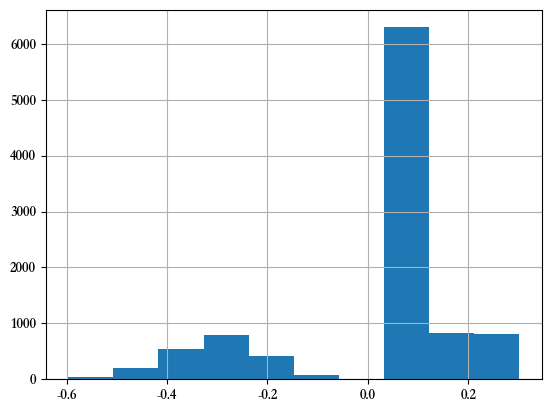

In [733]:
snowball_df['payoff'].hist()

In [734]:
snowball_df[snowball_df['knock_status'] == '敲入']['payoff'].describe()

count    2068.000000
mean       -0.302569
std         0.090038
min        -0.596728
25%        -0.363578
50%        -0.296570
75%        -0.239827
max        -0.093139
Name: payoff, dtype: float64

## 有限差分PDF计算Greeks

# 情景分析

完成雪球期权的情景分析。该内容为开放研究课题，可以从 多个维度对该雪球期权进行深入分析。(抛砖引玉：观察雪球 期权随着标的价格的变化而产生的希腊值变化; 观察雪球敲入 之后，希腊值的变化；观察雪球随着时间的流逝导致的希腊 值的变化; 观察不同锁定期、敲入敲出价格等参数的雪球期权 进行希腊值分析)

# 对冲交易

完成雪球期权对冲交易回测。利用股指期货, 对雪球期权进行 delta 对冲，并分析雪球期权整个生命周期的对冲盈亏。可以 选取不同开始日期的雪球期权，进行回测分析。

In [ ]:
import numpy as np
from scipy.stats import norm

def snowball_option_price(S, K1, K2, T, r, q, sigma):
    """
    计算雪球期权的定价
    :param S: 标的资产价格
    :param K1: 第一层敲入/敲出价格
    :param K2: 第二层敲入/敲出价格
    :param T: 到期时间（年）
    :param r: 无风险利率
    :param q: 远期股息率
    :param sigma: 标的资产价格波动率
    :return: 雪球期权的定价
    """
    d1 = (np.log(S / K1) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d3 = (np.log(S / K2) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d4 = d3 - sigma * np.sqrt(T)
    N = norm.cdf
    snowball_call = S * np.exp(-q * T) * (N(d1) - N(d3)) - K1 * np.exp(-r * T) * (N(d2) - N(d4)) + K2 * np.exp(-r * T) * (N(d2 - sigma * np.sqrt(T)) - N(d4 - sigma * np.sqrt(T)))
    snowball_put = S * np.exp(-q * T) * (N(-d3) - N(-d1)) + K1 * np.exp(-r * T) * (N(-d4) - N(-d2)) - K2 * np.exp(-r * T) * (N(-d4 + sigma * np.sqrt(T)) - N(-d2 + sigma * np.sqrt(T)))
    snowball_price = (snowball_call + snowball_put) / 2.0
    return snowball_price

def snowball_greeks(S, K1, K2, T, r, q, sigma):
    """
    计算雪球期权的希腊
    :param S: 标的资产价格
    :param K1: 第一层敲入/敲出价格
    :param K2: 第二层敲入/敲出价格
    :param T: 到期时间（年）
    :param r: 无风险利率
    :param q: 远期股息率
    :param sigma: 标的资产价格波动率
    :return: delta, gamma, vega, rho, theta
    """
    d1 = (np.log(S / K1) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d3 = (np.log(S / K2) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d4 = d3 - sigma * np.sqrt(T)
    N = norm.cdf
    n = norm.pdf
    delta_call = np.exp(-q * T) * (N(d1) - N(d3))
    delta_put = -np.exp(-q * T) * (N(-d3) - N(-d1))
    delta = (delta_call + delta_put) / 2.0
    gamma = np.exp(-q * T) * n(d1) / (S * sigma * np.sqrt(T) * 2.0)
    vega = S * np.exp(-q * T) * n(d1) * np.sqrt(T)
    rho_call = K1 * T * np.exp(-r * T) * (N(d2) - N(d4))
    rho_put = -K1 * T * np.exp(-r * T) * (N(-d4) - N(-d2))
    rho = (rho_call + rho_put) / 2.0
    theta_call = -(S * n(d1) * sigma * np.exp(-q * T)) / (2.0 * np.sqrt(T)) - r * K1 * np.exp(-r * T) * (N(d2) - N(d4)) + q * S * np.exp(-q * T) * (N(d1) - N(d3))
    theta_put = -(S * n(d1) * sigma * np.exp(-q * T)) / (2.0 * np.sqrt(T)) + r * K1 * np.exp(-r * T) * (N(-d4) - N(-d2)) - q * S * np.exp(-q * T) * (N(-d1) - N(-d3))
    theta = (theta_call + theta_put) / 2.0
    return delta, gamma, vega, rho, theta


In [ ]:
S = 100
K1 = 90
K2 = 120
T = 1
r = 0.05
q = 0.02
sigma = 0.3

price = snowball_option_price(S, K1, K2, T, r, q, sigma)
delta, gamma, vega, rho, theta = snowball_greeks(S, K1, K2, T, r, q, sigma)

print("Price: {:.4f}".format(price))
print("Delta: {:.4f}".format(delta))
print("Gamma: {:.4f}".format(gamma))
print("Vega: {:.4f}".format(vega))
print("Rho: {:.4f}".format(rho))
print("Theta: {:.4f}".format(theta))


Price: 35.8633
Delta: 0.0000
Gamma: 0.0054
Vega: 32.6391
Rho: 0.0000
Theta: -4.1786


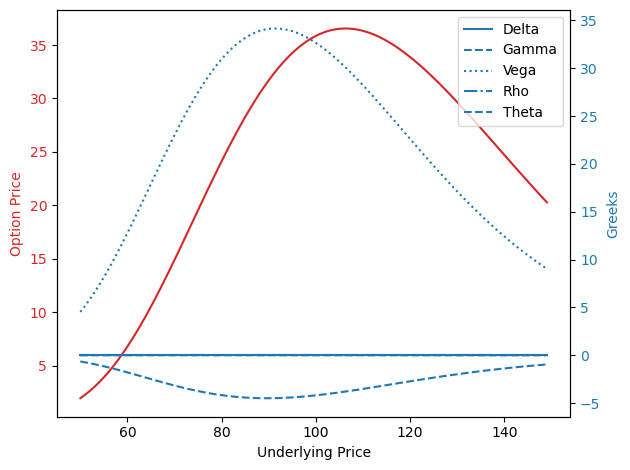

In [ ]:
import matplotlib.pyplot as plt

S_range = np.arange(50, 150, 1)
price_list = []
delta_list = []
gamma_list = []
vega_list = []
rho_list = []
theta_list = []

for S in S_range:
    price = snowball_option_price(S, K1, K2, T, r, q, sigma)
    delta, gamma, vega, rho, theta = snowball_greeks(S, K1, K2, T, r, q, sigma)
    price_list.append(price)
    delta_list.append(delta)
    gamma_list.append(gamma)
    vega_list.append(vega)
    rho_list.append(rho)
    theta_list.append(theta)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Underlying Price')
ax1.set_ylabel('Option Price', color=color)
ax1.plot(S_range, price_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Greeks', color=color)
ax2.plot(S_range, delta_list, label='Delta', color=color)
ax2.plot(S_range, gamma_list, label='Gamma', color=color, linestyle='--')
ax2.plot(S_range, vega_list, label='Vega', color=color, linestyle=':')
ax2.plot(S_range, rho_list, label='Rho', color=color, linestyle='-.')
ax2.plot(S_range, theta_list, label='Theta', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()
plt.show()


# 完成雪球期权的定价模型并计算出相关的希腊值（delta，gamma， vega，rho，theta）。

# Version 1.0 知乎

https://zhuanlan.zhihu.com/p/527393555

In [537]:
def simulation(S, r, T, sigma, I,dn = 0, steps = 1000, plotpath = False, plothist = False):
    """

    :param S: 初始价格
    :param r: 无风险收益率
    :param T: 到期期限（年）
    :param sigma: 波动率
    :param I: 路径
    :param dn: 敲入点
    :param steps:
    :param plotpath:
    :param plothist:
    :return:
    """
    delta_t = float(T)/steps
    Spath = np.zeros((steps + 1, I))
    Spath[0] = S

    for t in range(1, steps + 1):
        z = np.random.standard_normal(I)
        middle1 = Spath[t-1, 0:I] * np.exp((r - 0.5 * sigma ** 2) * delta_t + sigma * np.sqrt(delta_t) * z)
        uplimit = Spath[t-1] * 1.1
        lowlimit = Spath[t-1] * 0.9
        temp = np.where(uplimit < middle1, uplimit, middle1)
        temp = np.where(lowlimit > middle1, lowlimit, temp)
        Spath[t, 0:I] = temp

    if plotpath:
        plt.plot(Spath[:, :])
        plt.plot([dn]*len(Spath))
        plt.xlabel('time')
        plt.ylabel('price')
        plt.title('Price Simulation')
        plt.grid(True)
        plt.show()
        plt.close()

    if plothist:
        plt.hist(Spath[int(T*steps)], bins=50)
        plt.title('T moment price Histogram')
        plt.show()
        plt.close()

    return Spath

In [540]:
from tqdm import trange
def snowball_cashflow(price_path, coupon, I):
    payoff = np.zeros(I)
    knock_out_times = 0
    knock_in_times = 0
    existence_times = 0
    for i in trange(I):
        # 收盘价超过敲出线的交易日
        tmp_up_d = np.where(price_path[:, i] > k_out)
        # 收盘价超出敲出线的观察日
        tmp_up_m = tmp_up_d[0][tmp_up_d[0] % 21 == 0]
        # 收盘价超出敲出线的观察日（超过封闭期）
        tmp_up_m_md = tmp_up_m[tmp_up_m > lock_period]
        tmp_dn_d = np.where(price_path[:, i] < dn)
        # 根据合约条款判断现金流

        # 情景1：发生过向上敲出
        if len(tmp_up_m_md) > 0:
            t = tmp_up_m_md[0]
            payoff[i] = coupon * (t/252) * np.exp(-r * t/252)
            knock_out_times += 1

        # 情景2：未敲出且未敲入
        elif len(tmp_up_m_md) == 0 and len(tmp_dn_d[0]) == 0:
            payoff[i] = coupon * np.exp(-r * T)
            existence_times += 1

        # 情景3：只发生向下敲入，不发生向上敲出
        elif len(tmp_dn_d[0]) > 0 and len(tmp_up_m_md) == 0:
            # 只有向下敲入，没有向上敲出
            payoff[i] = 0 if price_path[len(price_path)-1][i] > 1 else (price_path[len(price_path)-1][i] - S) * np.exp(-r * T)
            knock_in_times += 1
        else:
            print(i)
    return payoff, knock_out_times, knock_in_times, existence_times

In [539]:
np.random.seed(0)
sigma = 0.13
T = 1
S = 1
r = 0.03
K = 1
I = 300000
dn = K * 0.85
k_out = S * (0.03 + 1)
lock_period = 0
coupon = 0.2
principal = 1

steps = 252 * T
price_path = simulation(S, r, T, sigma, I, dn=dn, steps=steps, plotpath=False, plothist=False)

payoff, knock_out_times, knock_in_times, existence_times = snowball_cashflow(price_path, coupon, I)
price = sum(payoff)/len(payoff)
print('snow_ball price: %f' % price)
print('knock_out_times: %f' % (knock_out_times/I))
print('knock_in_times: %f' % (knock_in_times/I))
print('existence_times: %f' % (existence_times/I))

snow_ball price: 0.050996
knock_out_times: 0.736517
knock_in_times: 0.126130
existence_times: 0.137353


## Version 2.0

Suppose you are a python expert, you are trying to teach me how to price snowball options using the Monte Carlo method. You should provide more examples, more in-depth knowledge

In [ ]:
strike_price = 100
reset_schedule = 30
num_simulations = 100000


In [ ]:
import numpy as np

def gbm_model(S0, r, sigma, T, N):
    dt = T/N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1)
    W = np.cumsum(W)*np.sqrt(dt)
    X = (r-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X)
    return S


In [ ]:
def snowball_payoff(S, K, schedule):
    num_resets = int(len(S) / schedule)
    max_price = K
    for i in range(num_resets):
        start_index = i * schedule
        end_index = (i + 1) * schedule
        max_price = max(max_price, np.max(S[start_index:end_index]))
    return max(S[-1] - max_price, 0)


In [ ]:
from tqdm import trange
payoffs = []
for i in trange(num_simulations):
    S = gbm_model(S0=100, r=0.05, sigma=0.2, T=1, N=365)
    payoff = snowball_payoff(S, strike_price, reset_schedule)
    payoffs.append(payoff)

100%|██████████| 100000/100000 [00:08<00:00, 11713.36it/s]


In [ ]:
option_price = np.mean(payoffs) * np.exp(-0.05)

In [ ]:
option_price

0.13700021832901824

# Version 4.0

In [ ]:
import numpy as np

def snowball_option_price(S, K, T, r, sigma, M):
    """
    Calculate the price of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    
    Returns the estimated price of the option.
    """
    dt = 1/252 # assume daily time steps
    
    # simulate M paths of the underlying asset's returns
    z = np.random.normal(size=(M, int(T/dt)))
    log_returns = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    log_prices = np.log(S) + np.cumsum(log_returns, axis=1)
    prices = np.exp(log_prices)
    
    # calculate the snowball payout for each path
    cum_returns = np.cumprod(prices > S, axis=1)
    payouts = K*np.sum(cum_returns*prices - S*cum_returns, axis=1)
    
    # calculate the expected payout and discount it back to present value
    expected_payout = np.mean(payouts)
    present_value = expected_payout*np.exp(-r*T)
    
    return present_value


In [ ]:
S = 100
K = 100
T = 1
r = 0.05
M = 30
num_simulations = 100000

snowball_option_price(S, K, T, r, sigma, M)

56304.03092055965

In [ ]:
def snowball_option_delta(S, K, T, r, sigma, M, ds=0.001):
    """
    Calculate the delta of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    ds: small change in the underlying asset price
    
    Returns the estimated delta of the option.
    """
    # calculate the option price for the initial asset price
    initial_price = snowball_option_price(S, K, T, r, sigma, M)
    
    # calculate the option price for a slightly higher asset price
    high_price = snowball_option_price(S+ds, K, T, r, sigma, M)
    
    # calculate the change in option price and estimate delta
    delta = (high_price - initial_price)/ds
    
    return delta


In [ ]:
def snowball_option_gamma(S, K, T, r, sigma, M, ds=0.001):
    """
    Calculate the gamma of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    ds: small change in the underlying asset price
    
    Returns the estimated gamma of the option.
    """
    # calculate the delta for the initial asset price
    initial_delta = snowball_option_delta(S, K, T, r, sigma, M)
    
    # calculate the delta for a slightly higher asset price
    high_delta = snowball_option_delta(S+ds, K, T, r, sigma, M)
    
    # calculate the change in delta and estimate gamma
    gamma = (high_delta - initial_delta)/ds
    
    return gamma


In [ ]:
def snowball_option_vega(S, K, T, r, sigma, M, ds=0.001):
    """
    Calculate the vega of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    ds: small change in the volatility
    
    Returns the estimated vega of the option.
    """
    # calculate the option price for the initial volatility
    initial_price = snowball_option_price(S, K, T, r, sigma, M)
    
    # calculate the option price for a slightly higher volatility
    high_price = snowball_option_price(S, K, T, r, sigma+ds, M)
    # calculate the change in option price and estimate vega
    vega = (high_price - initial_price)/ds

    return vega

    


4. Rho: Rho measures the sensitivity of the option price to changes in the risk-free interest rate. We can estimate rho by calculating the change in the option price for a small change in the interest rate.

In [ ]:

def snowball_option_rho(S, K, T, r, sigma, M, ds=0.001):
    """
    Calculate the rho of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    ds: small change in the interest rate
    
    Returns the estimated rho of the option.
    """
    # calculate the option price for the initial interest rate
    initial_price = snowball_option_price(S, K, T, r, sigma, M)
    
    # calculate the option price for a slightly higher interest rate
    high_price = snowball_option_price(S, K, T, r+ds, sigma, M)
    
    # calculate the change in option price and estimate rho
    rho = (high_price - initial_price)/ds
    
    return rho


In [ ]:
def snowball_option_theta(S, K, T, r, sigma, M, dt=0.001):
    """
    Calculate the theta of a snowball option using Monte Carlo simulation.
    
    S: initial price of the underlying asset
    K: strike price of the option
    T: time to maturity in years
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    M: number of Monte Carlo simulations
    dt: small change in the time to maturity
    
    Returns the estimated theta of the option.
    """
    # calculate the option price for the initial time to maturity
    initial_price = snowball_option_price(S, K, T, r, sigma, M)
    
    # calculate the option price for a slightly shorter time to maturity
    short_price = snowball_option_price(S, K, T-dt, r, sigma, M)
    
    # calculate the change in option price and estimate theta
    theta = (short_price - initial_price)/dt
    
    return theta


# bak

## bak-存一列有点麻烦。也许先算Payoff再存

In [239]:
_ = bs_model_price(S0, r_riskfree, sigma, T_years, len(date_index))
__ = np.concatenate([[_,_]],axis=1)
pd.DataFrame(__)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730
0,100.20292,100.400319,100.369216,99.428938,100.183451,100.014458,99.980249,100.650132,101.947495,102.997715,102.911017,101.247597,100.094636,98.95883,99.118102,99.642369,99.736448,99.836364,100.476838,100.991968,99.812815,99.725644,100.48449,101.184558,101.482595,101.245891,103.022019,103.241505,103.124237,103.672662,104.349724,105.183035,105.085874,105.116237,104.874121,105.649492,105.263039,104.113663,104.105097,103.383615,104.445428,104.873333,103.602368,104.258517,103.684338,101.00587,99.528462,98.408291,98.399218,97.423641,97.33011,96.113375,94.143029,95.346382,95.469586,94.401721,93.246931,92.769789,93.96878,95.24787,96.941947,97.933223,97.114404,96.63821,96.981606,96.460431,96.829698,98.487743,98.850128,98.411138,97.261858,96.887982,97.57702,96.940005,95.472286,93.444763,92.707463,93.008524,92.764324,93.388147,93.475865,94.643363,95.701792,96.411191,96.157358,96.528235,97.390239,98.517769,97.195513,98.027629,97.584384,97.335989,96.020702,95.537578,96.397026,96.571341,96.544096,96.076526,95.45863,95.859968,95.803164,97.387027,98.191275,96.647133,96.992972,98.484695,97.879084,97.527588,98.086933,98.060341,98.340601,97.921586,97.822742,98.360078,98.649252,98.625

In [240]:
from tqdm import trange
pd.set_option('display.max_columns', 10000)
stock_price_df = pd.DataFrame(index=date_index)

price_lst = list(bs_model_price(S0, r_riskfree, sigma, T_years, T_days))

for i in trange(10000):
    price_array_temp = bs_model_price(S0 r_riskfree, sigma, T_years, T_days)
    price_lst = price_lst + list(price_array_temp)
stock_price_df = pd.DataFrame(np.array(price_lst).reshape(-1,T_days),columns=date_index).T
stock_price_df

SyntaxError: invalid syntax (314479457.py, line 8)

In [ ]:
from tqdm import trange
pd.set_option('display.max_columns', 10000)
stock_price_df = pd.DataFrame(index=date_index)

for i in trange(10000):
    price_array_temp = bs_model_price(S0, r_riskfree, sigma, T_years, T_days)
    stock_price_df.loc[:,f'price_{i}'] = price_array_temp
stock_price_df

In [ ]:
from tqdm import trange
pd.set_option('display.max_columns', 10000)
stock_price_df = pd.DataFrame(index=date_index)

price_array = bs_model_price(S_0, r_riskfree, sigma, T_years, T_days)
price_array_temp = bs_model_price(S_0, r_riskfree, sigma, T_years, T_days)
price_array = np.concatenate([[price_array,price_array_temp]],axis=0)

for i in trange(10000):
    price_array_temp = bs_model_price(S_0, r_riskfree, sigma, T_years, T_days)
    price_array = np.concatenate([price_array,[price_array_temp]],axis=0)
stock_price_df = pd.DataFrame(price_array,columns=date_index).T
stock_price_df

In [ ]:
for i in trange(10000):
    bs_model_price(S_0, r_riskfree, sigma, T_years, len(date_index))

100%|██████████| 10000/10000 [00:00<00:00, 15335.02it/s]


## bak-定价-有点慢，提速下

In [ ]:
Position = 1e8
margin = 1
sigma = 0.16
r_riskfree = 0.03
q = 0.095
knock_out_coupon = 0.16
hold_coupon = 0.16
T_years = 2
lock_peroiod = 0.25 # 与敲出期有关，只锁定敲出不锁定敲入
knock_out_barrier = 1
knock_in_barrier = 0.75
stepdown = 0.005 # 这是逐级下调雪球产品，展示敲出期的变化规律
stepdown_start = 4/12

S0 = 1
K = S0

In [ ]:
import pandas as pd
start_date = pd.to_datetime('2021-01-05')
end_date = start_date + pd.DateOffset(years=T_years)
date_index = pd.date_range(start=start_date, end=end_date, freq='D')
T_days = len(date_index)
date_index

DatetimeIndex(['2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14',
               ...
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05'],
              dtype='datetime64[ns]', length=731, freq='D')

In [ ]:
import numpy as np
import pandas as pd
def bs_model_price(S0, r, sigma, T_years, T_days):
    dt = T_years/T_days
    t = np.linspace(0, T_years, T_days)
    W = np.random.standard_normal(size=T_days)
    W = np.cumsum(W)*np.sqrt(dt)
    X = (r-q-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X)
    return S


1. 每月观察期敲出，则终止并获得全部本金和年化敲出票息；

2. 没有敲入也没有敲出，则期末获得全部本金和年化红利票息；

3. 每日观察期敲入，期末未敲出，则获得与收益凭证本金相同的看跌空头，行权价为收益凭证本金相同数额。

In [ ]:
from datetime import datetime
date_lst = ['20210406', '20210506', '20210607', '20210705', '20210805', '20210906', '20211008', '20211105', '20211206', '20220105', '20220207', '20220307', '20220406', '20220505', '20220606', '20220705', '20220805', '20220905', '20221010', '20221107', '20221205', '20230105']
date_lst = [datetime.strptime(date, '%Y%m%d') for date in date_lst]
# stepdown_lst = [1.000,1.000, 1.000, 0.995, 0.990, 0.985, 0.980, 0.975, 0.970, 0.965, 0.960, 0.955, 0.950, 0.945, 0.940, 0.935, 0.930, 0.925, 0.920, 0.915, 0.910, 0.905]
stepdown_lst = [1.000] * 2 + [round(1 - 0.005 * i,3) for i in range(20)]

In [ ]:
def snowball_payoff(stock_array,date_index,date_lst,stepdown_lst,knock_in_barrier,S0):    
    stock_df = pd.DataFrame(stock_array, index=date_index, columns=['stock_price'])
    snow_df = stock_df.loc[date_lst,:]
    snow_df['knock_status'] = [1 if snow_df['stock_price'][i] > stepdown_lst[i] * S0 else -1 if snow_df['stock_price'][i] < knock_in_barrier * S0 else 0 for i in range(len(date_lst))]
    if snow_df['knock_status'].max() == 1: # 敲出吃利息
        time_delta = snow_df['knock_status'].idxmax() - start_date# 从这个时候贴现回来
        time_out = time_delta.days/365
        # payoff = (1 + knock_out_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
        payoff = (knock_out_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
        knock_status = '敲出'
    elif snow_df['knock_status'].min() == -1: # 敲入赔期权
        time_out = T_years
        # payoff = min(stock_array[-1]/S0,1) * np.exp(-r_riskfree * time_out) * margin
        payoff = min(stock_array[-1]-S0,0) * np.exp(-r_riskfree * time_out) * margin
        knock_status = '敲入'
    else:
        time_out = T_years
        # payoff = (1 + hold_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
        payoff = (hold_coupon * time_out) * np.exp(-r_riskfree * time_out) * margin
        knock_status = '未敲入敲出'
    return payoff,time_out, knock_status

In [ ]:
from tqdm import trange
pay_lst = []
time_out_lst = []
knock_status_lst = []
for i in trange(10000):
    stock_array = bs_model_price(S0, r_riskfree, sigma, T_years, len(date_index))
    pay, time_out, knock_status = snowball_payoff(stock_array,date_index,date_lst,stepdown_lst,knock_in_barrier,S0)
    pay_lst.append(pay)
    time_out_lst.append(time_out)
    knock_status_lst.append(knock_status)
np.mean(pay_lst)

In [ ]:
snowball_df = pd.DataFrame()
snowball_df['payoff'] = pay_lst
snowball_df['time (Year)'] = time_out_lst
snowball_df['time (Month)'] = snowball_df['time (Year)'] * 12
snowball_df['knock_status'] = knock_status_lst
snowball_descriptive_df = snowball_df.groupby('knock_status').mean()
snowball_distribution_df = (snowball_df['knock_status'].value_counts()/len(snowball_df)).rename('percent')
pd.concat([snowball_descriptive_df,snowball_distribution_df],axis=1)

,payoff,time (Year),time (Month),percent
敲入,-0.302569,2.000000,24.00000,0.2068
敲出,0.076572,0.490473,5.88568,0.7599
未敲入敲出,0.301365,2.000000,24.00000,0.0333


<AxesSubplot:>

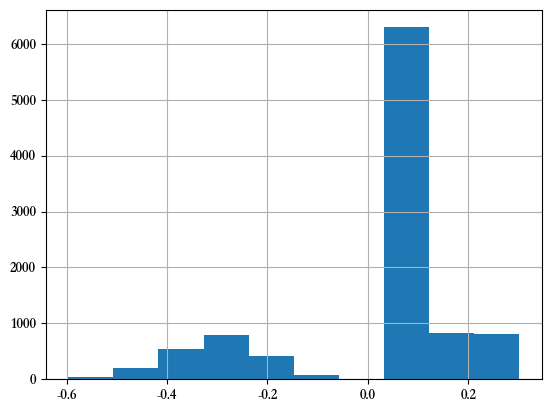

In [ ]:
snowball_df['payoff'].hist()